# Sprawozdanie 2
# Joanna Bryk


In [15]:
import numpy as np
from numpy import float32, float64
import matplotlib.pyplot as plt
import scipy.linalg as la

# Zadanie 1 

a) Na wykresach poniżej narysowane są wykresy funkcji - f(x) na niebiesko oraz p(x) wielomian interpolacyjny na pomarańczowo. Korzystałam z macierzy Vandermonde'a. 

In [16]:
def f(x):
    return 1./(1.+x**2)

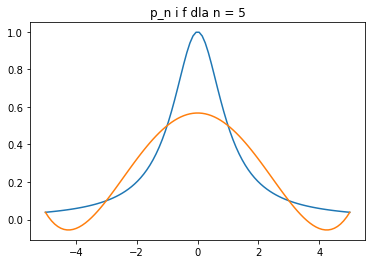

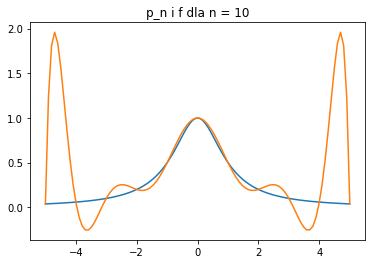

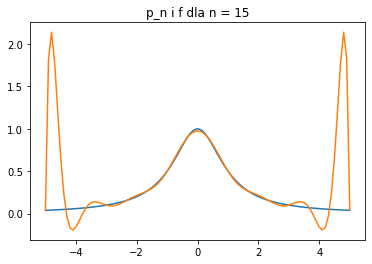

In [21]:
def interpolate_van(f, n):
    
    knots = np.linspace(-5, 5, n+1)
    func_values = [f(x) for x in knots]
    
    V = np.vander(knots, increasing = True) #potegi rosna od lewej do prawej
    a = la.solve(V, func_values) #tutaj są współczynniki
    float_a = [float64(item) for item in a]
    
#     print("kolejne wspolczynniki przy wielomianie p_n, potęgi przy x ułożone są rosnąco")
#     print(float_a)
    
    x_plot = np.linspace(-5,5,100)
    y_plot = [results(a,x) for x in x_plot] #ekstrapolacja
    
    plt.plot(x_plot,y_plot)
    plt.show()

def results(a,x):
    res = 0
    for i in range(len(a)):
        res+=a[i]*(x**i)
    return res
    

x = np.linspace(-5,5,100)
plt.title("p_n i f dla n = 5")    
plt.plot(x, f(x))
interpolate_van(f,5)

plt.title("p_n i f dla n = 10")    
plt.plot(x,f(x))
interpolate_van(f,10)

plt.title("p_n i f dla n = 15")    
plt.plot(x,f(x))
interpolate_van(f,15)
    

b) Na wykresach poniżej widocze są błędy obliczone wzorem e(x) = f(x) - p(x). Błąd zwiększa się przy krańcach przedziału. Jest to tak zwany efekt Rungego. W tym zadaniu również korzystałam z macierzy Vandermonde'a, jednak ćwiczeniowo, spróbowałam zaimplemenotwać interpolację metodą Lagrange'a.

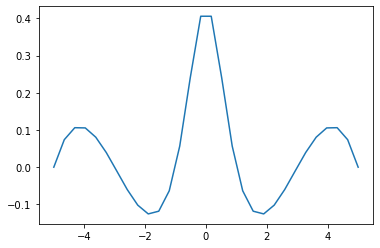

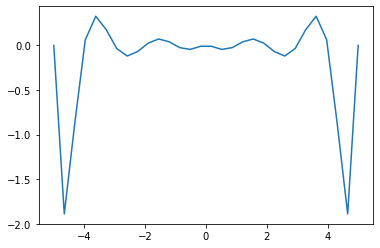

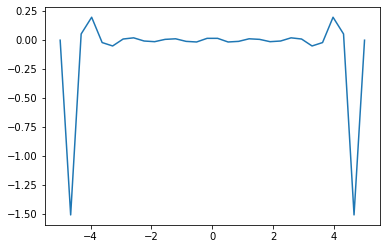

In [18]:
def interpolate_van_error(f, n):
 
    knots = np.linspace(-5, 5, n+1)
    func_values = [f(x) for x in knots]
    
    V = np.vander(knots, increasing = True) #potegi rosna od lewej do prawej
    a = la.solve(V, func_values) #tutaj są współczynniki
    
    x_plot = np.linspace(-5,5,30)
    y_plot = [results(a,x) for x in x_plot]
    error = [(f(i) - results(a,i)) for i in x_plot]  
    plt.plot(x_plot,error)
    plt.show()
    
interpolate_van_error(f, 5)
interpolate_van_error(f, 10)
interpolate_van_error(f, 15)


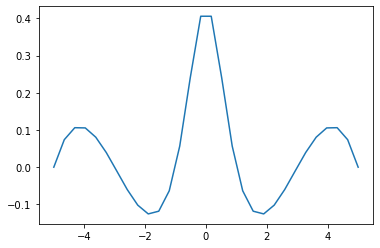

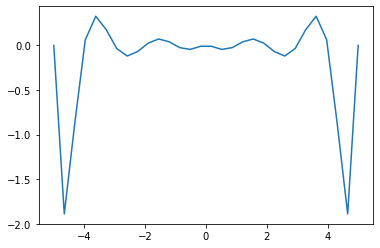

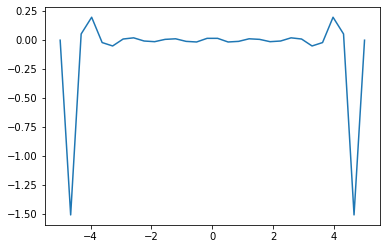

In [19]:
def interpolate_lagrange(X, Y, n, p):
    result = 0
    for i in range(n+1):
        k = Y[i]
        for j in range(n+1):
            if j!=i:
                k *= (p-X[j])/(X[i]-X[j])
        result +=k
    return result


def interpolate_lagrange_error(f, n):
    knots = np.linspace(-5,5,(n+1))
    func_values = [f(x) for x in knots]
    x_plot = np.linspace(-5,5, 30)
    error = []
    for i in x_plot:
        inter_value = interpolate_lagrange(knots,func_values, n, i)
        error.append( f(i) - inter_value) 
    plt.plot(x_plot,error)
    plt.show()

interpolate_lagrange_error(f, 5)
interpolate_lagrange_error(f, 10)
interpolate_lagrange_error(f, 15)


# Zadanie 2 

Dla danej funkcji i przedziału z poprzedniego zadania oraz n= 15 znajdź wielomian interpolacyjny w węzłach Czebyszewa,
xk=12(a+b)+12(b−a)cos(pi*(2k−1)/2n) gdzie k= 1,..,n a - początek, b - koniec 

W zadaniu wykorzystałam wzór podany w książce "Numerical mathematics and computing" . Licznik argumentu cosinusa jest bez zmian, jednak jest tam inny mianownik - 2*(n+1).

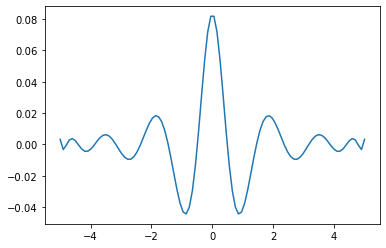

In [20]:
def interpolation_van_error_C(f, n, a, b):
 
    C_knots = [(0.5*(a+b)+0.5*(b-a)*np.cos(np.pi*(2*k+1)/(2*(n+1)))) for k in range (n + 1)]
    func_values = [f(x) for x in C_knots]
    x_plot = np.linspace(-5, 5, 100)
    V = np.vander(C_knots, increasing = True) #potegi rosna od lewej do prawej
    aa = la.solve(V, func_values) #tutaj są współczynniki
    
    x_plot = np.linspace(-5,5,100)
    y_plot = [results(aa,x) for x in x_plot]
    error = [(f(i) - results(aa,i)) for i in x_plot]  
    plt.plot(x_plot,error)
    plt.show()
    

interpolation_van_error_C(f, 15, -5, 5)


Błąd znacząco zmniejszył się. Szczególnie warto zwrócić uwagę na brak efektu Rungego na krańcach przedziału. Użycie węzłów Czebyszewa zamiast węzłów równoodległych jest dobrym sposobem na wyeliminowanie tego efektu.

# Zadanie 3

Zadanie polegało na zaimplementowaniu inteprolacji sześciennymi funkcjami sklejanymi dla 10 równoodległych punktów.
Następnie dla zadanego zbiotu punktów t należało narysować przybliżenie elipsy podanej w postaci parametrycznej.
    

Starałam się korzystać głównie ze wzorów podanych na wykładzie. Jest to wersja "natural cubic spline", gdzie jako brzegowe warunki przyjęłam, że s''(x_1) = s''(x_n) = 0, tzw. free boundary. W funkcji evaluate, gdzie obliczam wartości dla podanego x, skorzystałam ze wzoru znalezionego w książce "Numerical Mathematics and Computing" Cheney, Kincaid, ponieważ ten z wykładu z jakiegoś powodu nie działał. Nie do końca wiem, czemu tak się dzieje. 

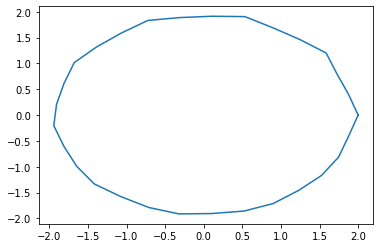

In [264]:
def x_t(t,a):
    return a*np.cos(t)
def y_t(t,a):
    return a*np.sin(t)

#funkcja wypełniania macierzy i obliczania (1/6)*s''
def interpolation_splines(n, f, a):
    knots = np.linspace(0, 2*np.pi, n+1)
    k_values = [f(x,a) for x in knots]
    
    h = [knots[i+1]-knots[i] for i in range(n)]
    b = [(k_values[i+1] - k_values[i])/h[i] for i in range(n)] 
  
    matrix_A = np.zeros((n+1, n+1))
    matrix_A[0][0] = 1
    matrix_A[n][n] = 1
    
    for i in range(1,n):
        if i - 1 >= 0 :
            matrix_A[i][i-1] = h[i-1]
        matrix_A[i][i] = 2*(h[i-1]+h[i])
        matrix_A[i][i+1] = h[i]
    
    matrix_B = np.zeros(n+1)
    matrix_B[0] = 0
    matrix_B[n] = 0
    for i in range(1,n):
        matrix_B[i] = b[i]-b[i-1]

    matrix_X = np.linalg.solve(matrix_A, matrix_B)
    
    return matrix_X

def evaluate(n, f, z, x, a):
    
    knots = np.linspace(0, 2*np.pi, n+1)
    k_values = [f(x,a) for x in knots]
    
    h = [knots[i+1]-knots[i] for i in range(n)]
    b = [(k_values[i+1] - k_values[i])/h[i] for i in range(n)]

    i = 0
    for j in range(n-1,-1,-1):
        if x - knots[j]>= 0:
            i = j
            break
    
#     a_i = k_values[i]
#     b_i = b[i]-h[i]*(z[i+1]-2*z[i])
#     c_i = 3*z[i]
#     d_i = (z[i+1]-z[i])/h[i]
#     res = a_i + b_i*(x - knots[i]) + c_i*(x-knots[i])**2+d_i*(x-knots[i])**3
#     return(res)
    
    tmp = (z[i]/2)+(x-knots[i])*(z[i+1]-z[i]/(6*h[i]))
    tmp1 = (-1)*(h[i]/6)*(z[i+1]+2*z[i])+(k_values[i+1]-k_values[i])/h[i]+(x-knots[i])*tmp
    return k_values[i]+(x-knots[i])*tmp1


def plot_inter_spline(n, f1, f2, a1, a2):
    z1 = interpolation_splines(n, f1, a1)
    z2 = interpolation_splines(n, f2, a2)
    t = np.linspace(0, 2*np.pi, 30)
    x_plot = [evaluate(n,f1,z1,x, a1) for x in t]
    y_plot = [evaluate(n,f2,z2,x, a2) for x in t]
    plt.plot(x_plot, y_plot)
    plt.show()
        

plot_inter_spline(10, x_t, y_t, 2, 2)
    